In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pairs = [['IEMG', 'EEM'], ['ARKK', 'ARKW'], ['TLT', 'SPTL'], ['SHY', 'VGSH'], ['SOXX', 'ITA']]

downloadable_tickers = [ticker for pair in pairs for ticker in pair]

training_data = yf.download(downloadable_tickers, start = '2015-01-01', end = '2020-01-01')['Close']
testing_data = yf.download(downloadable_tickers, start = '2020-01-02', end = '2024-12-31')['Close']

/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_1077/3707875857.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  training_data = yf.download(downloadable_tickers, start = '2015-01-01', end = '2020-01-01')['Close']
[*********************100%***********************]  10 of 10 completed
/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_1077/3707875857.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  testing_data = yf.download(downloadable_tickers, start = '2020-01-02', end = '2024-12-31')['Close']
[*********************100%***********************]  10 of 10 completed


In [4]:
def zscore_calc(series):
    return (series - series.mean()) / series.std()

In [5]:
training_spreads = {}
testing_spreads = {}

for etf1, etf2 in pairs:
    train_z1, train_z2 = zscore_calc(training_data[etf1]), zscore_calc(training_data[etf2])

    test_z1, test_z2 = zscore_calc(testing_data[etf1]), zscore_calc(testing_data[etf2])

    training_spread, testing_spread = train_z1 - train_z2, test_z1 - test_z2
    training_spreads[f'{etf1}_{etf2}'], testing_spreads[f'{etf1}_{etf2}'] = training_spread, testing_spread

training_spreads_df = pd.DataFrame(training_spreads)
testing_spreads_df = pd.DataFrame(testing_spreads)

In [6]:
def create_sequences(data, window_size):
    X, y  = [], []

    for i in range(len(data) - window_size):
        X.append(data.iloc[i : i + window_size])
        y.append(data.iloc[i + window_size])

        X_1 = np.array(X)
        y_1 = np.array(y)

    return torch.tensor(X_1, dtype = torch.float32), torch.tensor(y_1, dtype = torch.float32)

In [7]:
X_train, y_train = create_sequences(training_spreads_df['IEMG_EEM'], window_size = 30)
X_test, y_test = create_sequences(testing_spreads_df['IEMG_EEM'], window_size = 30)

In [8]:
class SpreadLSTM(nn.Module):
    def __init__(self, input_size = 1,  hidden_size = 1, num_layers = 1):
        super(SpreadLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.linear(out)
        return out

In [9]:
train_dataset = TensorDataset(X_train.unsqueeze(-1), y_train.unsqueeze(-1))
test_dataset = TensorDataset(X_test.unsqueeze(-1), y_test.unsqueeze(-1))

train_loader = DataLoader(train_dataset, batch_size = 64)
test_loader = DataLoader(test_dataset, batch_size = 64)

In [10]:
device = torch.device('cpu')
model = SpreadLSTM().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

epochs = 100
model.train()

for epoch in range(epochs):
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(train_loader):.4f}")
    

Epoch 1/100 - Loss: 1.1791
Epoch 2/100 - Loss: 1.0993
Epoch 3/100 - Loss: 1.0256
Epoch 4/100 - Loss: 0.9578
Epoch 5/100 - Loss: 0.8954
Epoch 6/100 - Loss: 0.8378
Epoch 7/100 - Loss: 0.7846
Epoch 8/100 - Loss: 0.7353
Epoch 9/100 - Loss: 0.6894
Epoch 10/100 - Loss: 0.6468
Epoch 11/100 - Loss: 0.6071
Epoch 12/100 - Loss: 0.5700
Epoch 13/100 - Loss: 0.5353
Epoch 14/100 - Loss: 0.5028
Epoch 15/100 - Loss: 0.4724
Epoch 16/100 - Loss: 0.4438
Epoch 17/100 - Loss: 0.4170
Epoch 18/100 - Loss: 0.3918
Epoch 19/100 - Loss: 0.3681
Epoch 20/100 - Loss: 0.3458
Epoch 21/100 - Loss: 0.3249
Epoch 22/100 - Loss: 0.3051
Epoch 23/100 - Loss: 0.2865
Epoch 24/100 - Loss: 0.2689
Epoch 25/100 - Loss: 0.2524
Epoch 26/100 - Loss: 0.2368
Epoch 27/100 - Loss: 0.2220
Epoch 28/100 - Loss: 0.2082
Epoch 29/100 - Loss: 0.1951
Epoch 30/100 - Loss: 0.1827
Epoch 31/100 - Loss: 0.1711
Epoch 32/100 - Loss: 0.1601
Epoch 33/100 - Loss: 0.1497
Epoch 34/100 - Loss: 0.1400
Epoch 35/100 - Loss: 0.1308
Epoch 36/100 - Loss: 0.1221
E

In [11]:
model.eval()
test_loss = 0
preds = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        preds.append(pred.cpu())
        loss = criterion(pred, yb)
        test_loss += loss.item()

print(f"Test Loss: {test_loss/len(test_loader):.4f}")

Test Loss: 0.0444


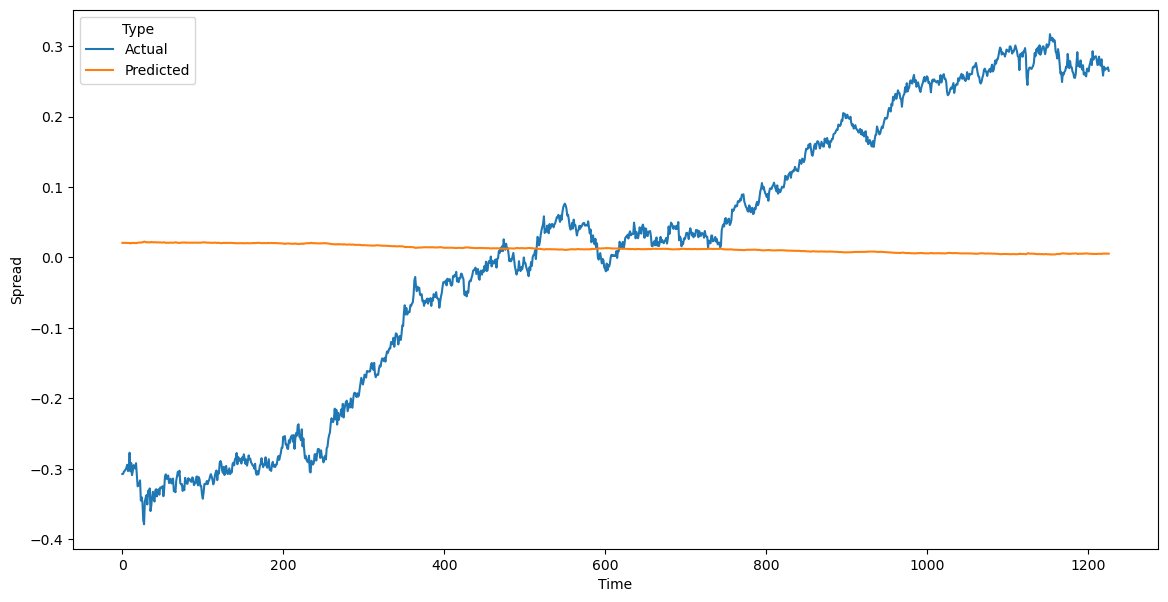

In [12]:
y_pred = torch.cat(preds).numpy()

y_pred_np = y_pred.flatten()
y_test_np = y_test.cpu().numpy().flatten()

plot_df = pd.DataFrame({
    'Time': range(len(y_test_np)),
    'Actual': y_test_np,
    'Predicted': y_pred_np
})

plot_df = plot_df.melt(id_vars = 'Time', value_vars = ['Actual', 'Predicted'], var_name = 'Type', value_name = 'Spread')

plt.subplots(figsize = (14, 7))

sns.lineplot(data = plot_df, x = 'Time', y = 'Spread', hue = 'Type')
plt.show()

In [13]:
def predict_mean_reversion(actual_spread, predicted_spread, threshold = 1):
    signals = []
    for current, pred in zip(actual_spread, predicted_spread):
        if current > threshold and current > pred:
            signals.append("short")
        elif current < -threshold and pred > current:
            signals.append("long")
        else:
            signals.append("hold")

    return pd.DataFrame({'actual': actual_spread,
                         'predicted': predicted_spread,
                         'signals': signals})

In [21]:
signals_df = predict_mean_reversion(y_test_np, y_pred_np, threshold = 0.4)

print(signals_df['signals'].value_counts())

signals
hold    1227
Name: count, dtype: int64


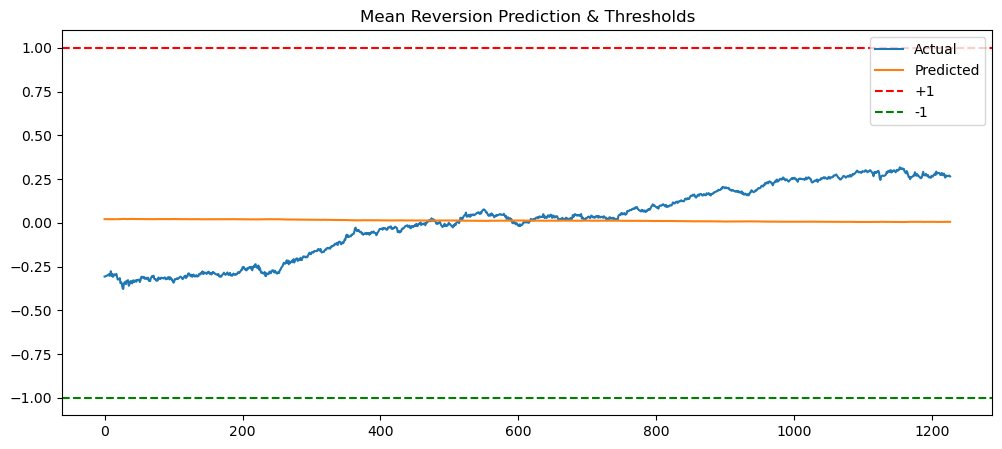

In [17]:
plt.figure(figsize=(12, 5))
plt.plot(signals_df['actual'], label="Actual")
plt.plot(signals_df['predicted'], label="Predicted")
plt.axhline(1, color='red', linestyle='--', label='+1')
plt.axhline(-1, color='green', linestyle='--', label='-1')
plt.title("Mean Reversion Prediction & Thresholds")
plt.legend()
plt.show()